In [1]:
import os

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision.transforms import v2
from torch.utils.data import Subset

from finetuning.aleket_dataset import AleketDataset, download_dataset
from finetuning.checkpoints import get_default_model, RunParams
from finetuning.metrics import Evaluator
from utils.analyze import count_analyze
from utils.infer import infer
from utils.visualize import visualize_bboxes, draw_heat_map
from utils.predictor import Predictor, postprocess
from utils.consts import NUM_TO_CLASSES, VALIDATION_METRICS


In [2]:
def visualize_samples(dataset, images_to_visualize=4):
    """
    Visualizes samples from the dataset with bounding boxes and labels.

    Args:
        dataset (AleketDataset): The dataset to visualize samples from.
        images_to_visualize (int, optional): The number of images to visualize. Defaults to 4.
    """
    visualized_images = []

    for id, annot in enumerate(dataset.get_annots(None)):
        if len(annot["boxes"]) > 0:
            img, target = dataset[id]
            img = v2.functional.to_pil_image(img)

            bboxes = target["boxes"].cpu().tolist()
            labels = [NUM_TO_CLASSES[label.item()] for label in target["labels"]]

            img_with_boxes = visualize_bboxes(img, bboxes, labels)
            visualized_images.append(img_with_boxes)
            if len(visualized_images) == images_to_visualize:
                break

    fig = plt.figure(figsize=(60, 20))
    columns = 4
    rows = 1
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(visualized_images[i - 1])
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

patched_dataset = AleketDataset(download_dataset("dataset_patched", ""))
full_dataset = AleketDataset(download_dataset("dataset_full_images", ""))

params = RunParams()
params.load("train_params.json")

model = get_default_model(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

print(f"Model loaded")

SAVE_DIR = "eval"
os.makedirs(SAVE_DIR)


In [ ]:
val_indices = full_dataset.to_indices(params.validation_set.keys())
val_subset = Subset(full_dataset, val_indices)
image_list = [f"{os.path.join(full_dataset.img_dir,name)}.jpeg" for name in params.validation_set.keys()]

with open("val_image_list.txt", "w") as f:
  for name in image_list:
    f.write(name + "\n") 
    
parsed_params = params.parse(model, patched_dataset)
train_dataloader = parsed_params["train_loader"]
val_dataloader = parsed_params["val_loader"]
augmentation = parsed_params["augmentation"]

count_analyze(full_dataset.get_annots(), save_folder="full_dataset_statistics")
count_analyze(patched_dataset.get_annots(train_dataloader.dataset.indices), save_folder="patched_dataset__train_statistics")
count_analyze(patched_dataset.get_annots(val_dataloader.dataset.indices), save_folder="patched_dataset_val_statistics")

patched_dataset.augmentation = augmentation
visualize_samples(patched_dataset)

In [11]:
predictor = Predictor(
    model,
    device,
    detections_per_patch=150,
    detections_per_image=500,
    image_size_factor=1,
    patches_per_batch=4,
)

iou_thrs = np.round(np.flip(np.arange(0.1, 0.5 + 1e-3, 0.05)), 2)
score_thrs = np.round(np.arange(0.05, 0.95 + 1e-4, 0.05), 2)

np.savetxt(os.path.join(SAVE_DIR, "iou_thrs.csv"), iou_thrs, delimiter=",", fmt="%.2f")
np.savetxt(
    os.path.join(SAVE_DIR, "score_thrs.csv"), score_thrs, delimiter=",", fmt="%.2f"
)

N = len(iou_thrs)
S = len(score_thrs)

eval = Evaluator(full_dataset.get_annots(val_indices), use_categories=False)

eval_res = {}
results_ap = np.full((N, S), -1.0)
results_p = np.full((N, S), -1.0)
results_r = np.full((N, S), -1.0)
results_aad = np.full((N, S), -1.0)
results_acd = np.full((N, S), -1.0)

In [ ]:
preds = predictor.get_predictions(val_subset, 1, 0.05) # disable postprocess (using small scorethreshold to increase performance)
print("start analyzing...")
for i, iou_thresh in enumerate(iou_thrs):
    for j, score_thresh in tqdm(enumerate(score_thrs), total=S):
        try:
            postproccessed = {}
            for pi, p in preds.items():
                to_process = {
                    "boxes": np.copy(p["boxes"]),
                    "scores": np.copy(p["scores"]),
                    "labels": np.copy(p["labels"])
                }
                postproccessed[pi] = postprocess(to_process,predictor.detections_per_image, score_thresh, iou_thresh)
            stats = eval.eval(postproccessed)
            eval_res[(i, j)] = eval.eval_res
            results_ap[i, j] = stats[VALIDATION_METRICS[0]]
            results_acd[i, j] = stats[VALIDATION_METRICS[-2]]
            results_aad[i, j] = stats[VALIDATION_METRICS[-1]]
            results_p[i, j] = stats[VALIDATION_METRICS[2]]
            results_r[i, j] = stats[VALIDATION_METRICS[1]]
        except Exception as e:
            raise e
            print(e)

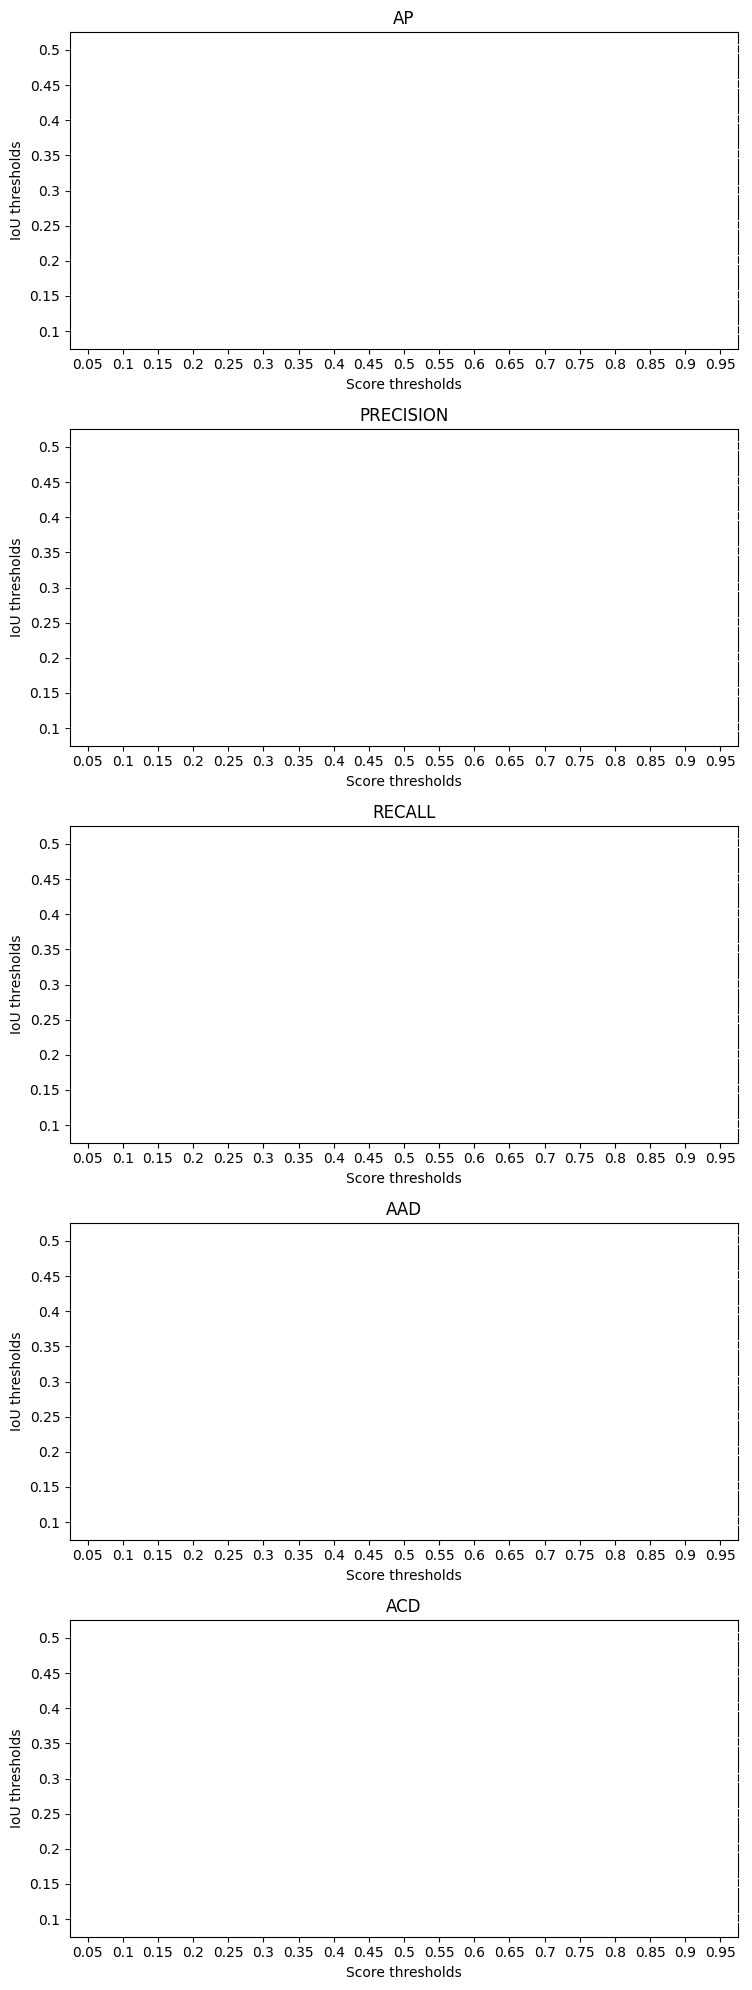

In [ ]:
np.savetxt(
    os.path.join(SAVE_DIR, "ap_analysis.csv"), results_ap, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "aad_analysis.csv"), results_aad, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "acd_analysis.csv"), results_acd, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "r_analysis.csv"), results_r, delimiter=",", fmt="%.4f"
)
np.savetxt(
    os.path.join(SAVE_DIR, "p_analysis.csv"), results_p, delimiter=",", fmt="%.4f"
)


fig, axes = plt.subplots(5, 1, figsize=(150, 20))

draw_heat_map("AP", "Score thresholds", "IoU thresholds", results_ap, axes[0], score_thrs, iou_thrs)
draw_heat_map("PRECISION", "Score thresholds", "IoU thresholds", results_p, axes[1], score_thrs, iou_thrs)
draw_heat_map("RECALL", "Score thresholds", "IoU thresholds", results_r, axes[2], score_thrs, iou_thrs)
draw_heat_map("AAD", "Score thresholds", "IoU thresholds", results_aad, axes[3], score_thrs, iou_thrs)
draw_heat_map("ACD", "Score thresholds", "IoU thresholds", results_acd, axes[4], score_thrs, iou_thrs)

plt.tight_layout()
plt.show()

In [ ]:
BEST_IOU_THRESH = 0.15
BEST_SCORE_THRESH = 0.75

preds = predictor.get_predictions(val_subset, BEST_IOU_THRESH, BEST_SCORE_THRESH)
stats = eval.eval(preds)

print("ALL CLASSES METRICS:")
for metric_name, metric_value in stats.items():
    print(f"\tValidation {metric_name}: {metric_value:.3f}")

np.savetxt(os.path.join(SAVE_DIR, "pr_recalls.csv"), eval.recall_thrs, fmt='%.4f')
np.savetxt(os.path.join(SAVE_DIR, "pr_curve.csv"), eval.eval_res["pr_curve"], fmt='%.4f')

In [ ]:
infer(
    predictor,
    image_list,
    NUM_TO_CLASSES,
    os.path.join(SAVE_DIR, "infer"),
    iou_thresh=BEST_IOU_THRESH,
    score_thresh=BEST_SCORE_THRESH,
    save_annots=True,
    save_images=True,
)